In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [3]:
from matplotlib.pylab import rcParams

In [4]:
import matplotlib

In [5]:
import shap

In [6]:
pd.plotting.register_matplotlib_converters()


In [7]:
df = pd.read_csv('2018_2019.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3429002 entries, 0 to 3429001
Data columns (total 14 columns):
Unnamed: 0        int64
date              object
train_id          object
stop_sequence     float64
from              object
from_id           float64
to                object
to_id             float64
scheduled_time    object
actual_time       object
delay_minutes     float64
status            object
line              object
type              object
dtypes: float64(4), int64(1), object(9)
memory usage: 366.3+ MB


In [8]:
df = df.drop('Unnamed: 0', axis=1)

In [9]:
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [10]:
df.tail()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
3428997,2019-04-30,1629,5.0,Nanuet,100.0,Spring Valley,142.0,2019-04-30 18:25:00,2019-04-30 18:27:00,2.0,estimated,Pascack Valley,NJ Transit
3428998,2019-04-30,A2124,NaN,Philadelphia,1.0,Philadelphia,1.0,NaN,2019-04-30 19:28:49,NaN,departed,ACELA EXPRESS,Amtrak
3428999,2019-04-30,A2124,NaN,Philadelphia,1.0,Metropark,83.0,NaN,2019-04-30 20:16:23,NaN,departed,ACELA EXPRESS,Amtrak
3429000,2019-04-30,A2124,NaN,Metropark,83.0,Newark Penn Station,107.0,NaN,2019-04-30 20:30:53,NaN,departed,ACELA EXPRESS,Amtrak
3429001,2019-04-30,A2124,NaN,Newark Penn Station,107.0,New York Penn Station,105.0,NaN,2019-04-30 20:49:04,NaN,departed,ACELA EXPRESS,Amtrak


# Maybe do something with the more granular scheduled_and actual_ time hours and minutes of the day

In [11]:
df.index

RangeIndex(start=0, stop=3429002, step=1)

In [12]:
len(df)

3429002

In [13]:
df.isnull().sum()

date                   0
train_id               0
stop_sequence     278718
from                   0
from_id              891
to                     0
to_id                891
scheduled_time    278718
actual_time            0
delay_minutes     278718
status                 0
line                   0
type                   0
dtype: int64

# To Prophet friendly format

In [14]:
df= df.rename(columns={'date':'ds',
                     'delay_minutes':'y'})

df.head()

,ds,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,y,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [15]:
df = df.drop(df[['from_id', 'to_id']], axis=1)

df.head()

,ds,train_id,stop_sequence,from,to,scheduled_time,actual_time,y,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,New York Penn Station,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,Secaucus Upper Lvl,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,Newark Penn Station,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,Newark Airport,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,North Elizabeth,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [16]:
df['stop_sequence'].value_counts()

1.0     240780
2.0     239284
4.0     222902
5.0     222870
3.0     222586
6.0     219741
7.0     213099
8.0     209322
9.0     202629
10.0    192389
11.0    174249
12.0    160506
13.0    138329
14.0    110448
15.0     93212
16.0     82612
17.0     64177
18.0     48105
19.0     23560
20.0     19421
21.0     13971
22.0     10893
23.0     10056
24.0      9938
25.0      3260
26.0      1945
Name: stop_sequence, dtype: int64

# Dummy variables for categorical

In [17]:
dummy = pd.get_dummies(df['from'], prefix="from_")

dummy.head()

,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,from__Asbury Park,from__Atco,from__Atlantic City Rail Terminal,from__Avenel,...,from__Watchung Avenue,from__Watsessing Avenue,from__Wayne-Route 23,from__Wesmont,from__Westfield,from__Westwood,from__White House,from__Wood Ridge,from__Woodbridge,from__Woodcliff Lake
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df = pd.concat([df, dummy], axis=1) 
df.head()

,ds,train_id,stop_sequence,from,to,scheduled_time,actual_time,y,status,line,...,from__Watchung Avenue,from__Watsessing Avenue,from__Wayne-Route 23,from__Wesmont,from__Westfield,from__Westwood,from__White House,from__Wood Ridge,from__Woodbridge,from__Woodcliff Lake
0,2018-03-01,3805,1.0,New York Penn Station,New York Penn Station,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
1,2018-03-01,3805,2.0,New York Penn Station,Secaucus Upper Lvl,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,Newark Penn Station,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
3,2018-03-01,3805,4.0,Newark Penn Station,Newark Airport,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
4,2018-03-01,3805,5.0,Newark Airport,North Elizabeth,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dummy = pd.get_dummies(df['to'],prefix="to_")

dummy.head()

,to__Aberdeen-Matawan,to__Absecon,to__Allendale,to__Allenhurst,to__Anderson Street,to__Annandale,to__Asbury Park,to__Atco,to__Atlantic City Rail Terminal,to__Avenel,...,to__Watchung Avenue,to__Watsessing Avenue,to__Wayne-Route 23,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df = pd.concat([df, dummy], axis=1) 
df.head()

,ds,train_id,stop_sequence,from,to,scheduled_time,actual_time,y,status,line,...,to__Watchung Avenue,to__Watsessing Avenue,to__Wayne-Route 23,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake
0,2018-03-01,3805,1.0,New York Penn Station,New York Penn Station,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
1,2018-03-01,3805,2.0,New York Penn Station,Secaucus Upper Lvl,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,Newark Penn Station,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
3,2018-03-01,3805,4.0,Newark Penn Station,Newark Airport,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0
4,2018-03-01,3805,5.0,Newark Airport,North Elizabeth,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df = df.drop(['from','to'],axis=1)

df.head()

,ds,train_id,stop_sequence,scheduled_time,actual_time,y,status,line,type,from__Aberdeen-Matawan,...,to__Watchung Avenue,to__Watsessing Avenue,to__Wayne-Route 23,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake
0,2018-03-01,3805,1.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-03-01,3805,2.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-03-01,3805,3.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-03-01,3805,4.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-03-01,3805,5.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df.columns

Index(['ds', 'train_id', 'stop_sequence', 'scheduled_time', 'actual_time', 'y',
       'status', 'line', 'type', 'from__Aberdeen-Matawan',
       ...
       'to__Watchung Avenue', 'to__Watsessing Avenue', 'to__Wayne-Route 23',
       'to__Wesmont', 'to__Westfield', 'to__Westwood', 'to__White House',
       'to__Wood Ridge', 'to__Woodbridge', 'to__Woodcliff Lake'],
      dtype='object', length=343)

In [25]:
df = df.dropna(axis=0, subset=['y'])
df.isnull().sum()

ds                    0
train_id              0
stop_sequence         0
scheduled_time        0
actual_time           0
                     ..
to__Westwood          0
to__White House       0
to__Wood Ridge        0
to__Woodbridge        0
to__Woodcliff Lake    0
Length: 343, dtype: int64

In [26]:
len(df)

3150284

# Converting ds to datetime and setting as index

In [27]:
df['ds'] = pd.to_datetime(df['ds'])
df.dtypes

ds                    datetime64[ns]
train_id                      object
stop_sequence                float64
scheduled_time                object
actual_time                   object
                           ...      
to__Westwood                   uint8
to__White House                uint8
to__Wood Ridge                 uint8
to__Woodbridge                 uint8
to__Woodcliff Lake             uint8
Length: 343, dtype: object

In [28]:
df.y.value_counts().sort_index()

0.000000      403870
0.016667        6640
0.033333        9769
0.050000       12445
0.066667       14764
               ...  
153.133333         1
162.000000         2
163.000000         1
325.000000         4
326.000000         2
Name: y, Length: 4543, dtype: int64

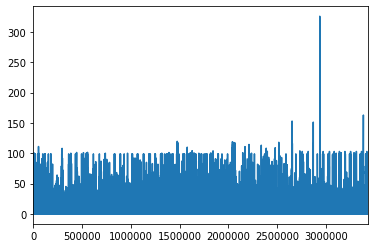

In [29]:
df['y'].plot()

In [30]:
df.loc[df['y'] < np.percentile(df['y'],95)]

,ds,train_id,stop_sequence,scheduled_time,actual_time,y,status,line,type,from__Aberdeen-Matawan,...,to__Watchung Avenue,to__Watsessing Avenue,to__Wayne-Route 23,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake
0,2018-03-01,3805,1.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-03-01,3805,2.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-03-01,3805,3.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-03-01,3805,4.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-03-01,3805,5.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428993,2019-04-30,1629,1.0,2019-04-30 17:32:00,2019-04-30 17:32:14,0.233333,departed,Pascack Valley,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
3428994,2019-04-30,1629,2.0,2019-04-30 17:43:00,2019-04-30 17:46:00,3.000000,departed,Pascack Valley,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
3428995,2019-04-30,1629,3.0,2019-04-30 18:14:00,2019-04-30 18:17:59,3.983333,departed,Pascack Valley,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0
3428996,2019-04-30,1629,4.0,2019-04-30 18:20:00,2019-04-30 18:23:41,3.683333,departed,Pascack Valley,NJ Transit,0,...,0,0,0,0,0,0,0,0,0,0


# Resampling for a smaller dataframe for Prophet to work on

In [31]:
df = df.set_index('ds')
df_daily = df.resample(rule="D").sum()

df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2018-03-01 to 2019-04-30
Freq: D
Columns: 336 entries, stop_sequence to to__Woodcliff Lake
dtypes: float64(336)
memory usage: 1.1 MB


In [ ]:
df_daily.head()

# Plot of time series of delays

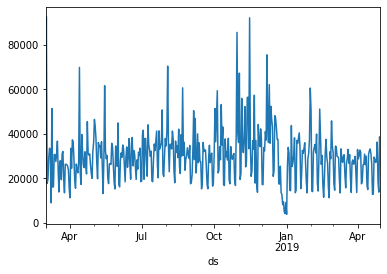

In [32]:
df_daily['y'].plot()

In [33]:
df_no_zero =df_daily[df_daily.y != 0]

In [34]:
df_no_zero.head()

,stop_sequence,y,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,from__Asbury Park,from__Atco,...,to__Watchung Avenue,to__Watsessing Avenue,to__Wayne-Route 23,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake
ds,,,,,,,,,,,,,,,,,,,,,
2018-03-01,74474.0,38248.733333,64.0,21.0,54.0,32.0,32.0,16.0,32.0,21.0,...,59.0,49.0,14.0,36.0,48.0,29.0,16.0,31.0,77.0,24.0
2018-03-02,78222.0,92729.650000,66.0,24.0,57.0,34.0,35.0,17.0,34.0,24.0,...,60.0,49.0,14.0,37.0,51.0,32.0,17.0,34.0,77.0,27.0
2018-03-03,40376.0,17608.116667,37.0,23.0,34.0,21.0,19.0,0.0,21.0,23.0,...,0.0,19.0,0.0,24.0,35.0,19.0,0.0,19.0,37.0,0.0
2018-03-04,39729.0,19506.866667,38.0,23.0,34.0,31.0,19.0,0.0,31.0,23.0,...,0.0,17.0,0.0,24.0,34.0,19.0,0.0,19.0,38.0,1.0
2018-03-05,77932.0,28857.733333,65.0,23.0,55.0,34.0,34.0,17.0,34.0,23.0,...,62.0,51.0,14.0,36.0,50.0,31.0,17.0,33.0,78.0,26.0


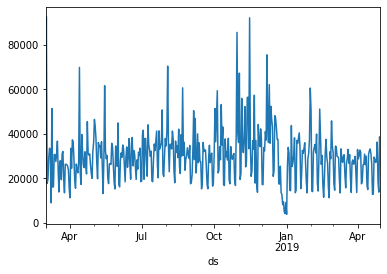

In [35]:
df_no_zero['y'].plot()

plt.show()

# Decomposition

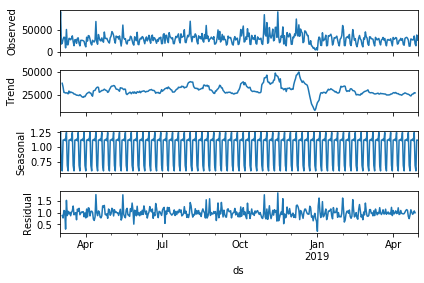

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_no_zero['y'], model='mul')
ax = result.plot()

# TBD:EDA

# Outlier removal

In [37]:
len(df_no_zero)

426

In [38]:
df_no_zero.loc[df_no_zero['y'] < np.percentile(df_no_zero['y'],95)]

,stop_sequence,y,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,from__Asbury Park,from__Atco,...,to__Watchung Avenue,to__Watsessing Avenue,to__Wayne-Route 23,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake
ds,,,,,,,,,,,,,,,,,,,,,
2018-03-01,74474.0,38248.733333,64.0,21.0,54.0,32.0,32.0,16.0,32.0,21.0,...,59.0,49.0,14.0,36.0,48.0,29.0,16.0,31.0,77.0,24.0
2018-03-03,40376.0,17608.116667,37.0,23.0,34.0,21.0,19.0,0.0,21.0,23.0,...,0.0,19.0,0.0,24.0,35.0,19.0,0.0,19.0,37.0,0.0
2018-03-04,39729.0,19506.866667,38.0,23.0,34.0,31.0,19.0,0.0,31.0,23.0,...,0.0,17.0,0.0,24.0,34.0,19.0,0.0,19.0,38.0,1.0
2018-03-05,77932.0,28857.733333,65.0,23.0,55.0,34.0,34.0,17.0,34.0,23.0,...,62.0,51.0,14.0,36.0,50.0,31.0,17.0,33.0,78.0,26.0
2018-03-06,78460.0,33491.766667,65.0,22.0,57.0,34.0,33.0,17.0,34.0,22.0,...,61.0,51.0,14.0,37.0,51.0,30.0,17.0,32.0,78.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26,68999.0,36258.850000,54.0,0.0,52.0,28.0,34.0,11.0,28.0,0.0,...,60.0,49.0,13.0,34.0,30.0,32.0,11.0,33.0,68.0,27.0
2019-04-27,34896.0,18306.150000,37.0,0.0,34.0,21.0,17.0,0.0,21.0,0.0,...,0.0,19.0,0.0,23.0,31.0,17.0,0.0,17.0,37.0,0.0
2019-04-28,34294.0,13713.366667,37.0,0.0,34.0,18.0,19.0,0.0,18.0,0.0,...,0.0,17.0,0.0,23.0,33.0,19.0,0.0,19.0,37.0,1.0


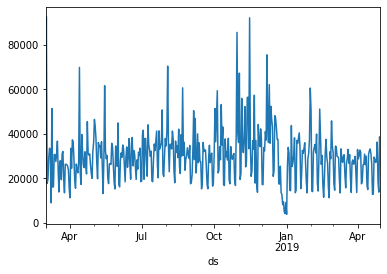

In [39]:
df_no_zero['y'].plot()

plt.show()

# Split to train and test

In [40]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['ds'] = df.index
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    
    X = df.append(['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'])
    return X

In [41]:
df_features = create_features(df_no_zero)
df_features.head()

,0,dayofmonth,dayofweek,dayofyear,ds,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,...,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake,weekofyear,y,year
2018-03-01 00:00:00,NaN,1.0,3.0,60.0,2018-03-01,64.0,21.0,54.0,32.0,32.0,...,36.0,48.0,29.0,16.0,31.0,77.0,24.0,9.0,38248.733333,2018.0
2018-03-02 00:00:00,NaN,2.0,4.0,61.0,2018-03-02,66.0,24.0,57.0,34.0,35.0,...,37.0,51.0,32.0,17.0,34.0,77.0,27.0,9.0,92729.650000,2018.0
2018-03-03 00:00:00,NaN,3.0,5.0,62.0,2018-03-03,37.0,23.0,34.0,21.0,19.0,...,24.0,35.0,19.0,0.0,19.0,37.0,0.0,9.0,17608.116667,2018.0
2018-03-04 00:00:00,NaN,4.0,6.0,63.0,2018-03-04,38.0,23.0,34.0,31.0,19.0,...,24.0,34.0,19.0,0.0,19.0,38.0,1.0,9.0,19506.866667,2018.0
2018-03-05 00:00:00,NaN,5.0,0.0,64.0,2018-03-05,65.0,23.0,55.0,34.0,34.0,...,36.0,50.0,31.0,17.0,33.0,78.0,26.0,10.0,28857.733333,2018.0


In [42]:
df_features= df_features.drop(0, axis=1)

In [43]:
df_features.head()


,dayofmonth,dayofweek,dayofyear,ds,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,...,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake,weekofyear,y,year
2018-03-01 00:00:00,1.0,3.0,60.0,2018-03-01,64.0,21.0,54.0,32.0,32.0,16.0,...,36.0,48.0,29.0,16.0,31.0,77.0,24.0,9.0,38248.733333,2018.0
2018-03-02 00:00:00,2.0,4.0,61.0,2018-03-02,66.0,24.0,57.0,34.0,35.0,17.0,...,37.0,51.0,32.0,17.0,34.0,77.0,27.0,9.0,92729.650000,2018.0
2018-03-03 00:00:00,3.0,5.0,62.0,2018-03-03,37.0,23.0,34.0,21.0,19.0,0.0,...,24.0,35.0,19.0,0.0,19.0,37.0,0.0,9.0,17608.116667,2018.0
2018-03-04 00:00:00,4.0,6.0,63.0,2018-03-04,38.0,23.0,34.0,31.0,19.0,0.0,...,24.0,34.0,19.0,0.0,19.0,38.0,1.0,9.0,19506.866667,2018.0
2018-03-05 00:00:00,5.0,0.0,64.0,2018-03-05,65.0,23.0,55.0,34.0,34.0,17.0,...,36.0,50.0,31.0,17.0,33.0,78.0,26.0,10.0,28857.733333,2018.0


In [44]:
df_features = df_features.set_index('ds')

df_features.head()

,dayofmonth,dayofweek,dayofyear,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,from__Asbury Park,...,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake,weekofyear,y,year
ds,,,,,,,,,,,,,,,,,,,,,
2018-03-01,1.0,3.0,60.0,64.0,21.0,54.0,32.0,32.0,16.0,32.0,...,36.0,48.0,29.0,16.0,31.0,77.0,24.0,9.0,38248.733333,2018.0
2018-03-02,2.0,4.0,61.0,66.0,24.0,57.0,34.0,35.0,17.0,34.0,...,37.0,51.0,32.0,17.0,34.0,77.0,27.0,9.0,92729.650000,2018.0
2018-03-03,3.0,5.0,62.0,37.0,23.0,34.0,21.0,19.0,0.0,21.0,...,24.0,35.0,19.0,0.0,19.0,37.0,0.0,9.0,17608.116667,2018.0
2018-03-04,4.0,6.0,63.0,38.0,23.0,34.0,31.0,19.0,0.0,31.0,...,24.0,34.0,19.0,0.0,19.0,38.0,1.0,9.0,19506.866667,2018.0
2018-03-05,5.0,0.0,64.0,65.0,23.0,55.0,34.0,34.0,17.0,34.0,...,36.0,50.0,31.0,17.0,33.0,78.0,26.0,10.0,28857.733333,2018.0


In [45]:
split_date = '2019-04-01' #or -01
df_train = df_features.loc[df_features.index <= split_date].copy()
df_test = df_features.loc[df_features.index > split_date].copy()

In [46]:
df_train = df_train.reset_index()

df_train.head()

,ds,dayofmonth,dayofweek,dayofyear,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,...,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake,weekofyear,y,year
0,2018-03-01,1.0,3.0,60.0,64.0,21.0,54.0,32.0,32.0,16.0,...,36.0,48.0,29.0,16.0,31.0,77.0,24.0,9.0,38248.733333,2018.0
1,2018-03-02,2.0,4.0,61.0,66.0,24.0,57.0,34.0,35.0,17.0,...,37.0,51.0,32.0,17.0,34.0,77.0,27.0,9.0,92729.650000,2018.0
2,2018-03-03,3.0,5.0,62.0,37.0,23.0,34.0,21.0,19.0,0.0,...,24.0,35.0,19.0,0.0,19.0,37.0,0.0,9.0,17608.116667,2018.0
3,2018-03-04,4.0,6.0,63.0,38.0,23.0,34.0,31.0,19.0,0.0,...,24.0,34.0,19.0,0.0,19.0,38.0,1.0,9.0,19506.866667,2018.0
4,2018-03-05,5.0,0.0,64.0,65.0,23.0,55.0,34.0,34.0,17.0,...,36.0,50.0,31.0,17.0,33.0,78.0,26.0,10.0,28857.733333,2018.0


In [47]:
df_test = df_test.reset_index()

df_test.head()

,ds,dayofmonth,dayofweek,dayofyear,from__Aberdeen-Matawan,from__Absecon,from__Allendale,from__Allenhurst,from__Anderson Street,from__Annandale,...,to__Wesmont,to__Westfield,to__Westwood,to__White House,to__Wood Ridge,to__Woodbridge,to__Woodcliff Lake,weekofyear,y,year
0,2019-04-02,2.0,1.0,92.0,52.0,0.0,50.0,25.0,31.0,11.0,...,32.0,31.0,29.0,11.0,30.0,66.0,24.0,14.0,28680.116667,2019.0
1,2019-04-03,3.0,2.0,93.0,51.0,0.0,50.0,27.0,33.0,11.0,...,33.0,31.0,31.0,11.0,32.0,65.0,26.0,14.0,29932.700000,2019.0
2,2019-04-04,4.0,3.0,94.0,52.0,0.0,49.0,25.0,31.0,11.0,...,32.0,30.0,29.0,11.0,30.0,66.0,24.0,14.0,32657.966667,2019.0
3,2019-04-05,5.0,4.0,95.0,54.0,0.0,52.0,28.0,34.0,11.0,...,34.0,32.0,32.0,11.0,33.0,68.0,27.0,14.0,31662.616667,2019.0
4,2019-04-06,6.0,5.0,96.0,37.0,0.0,34.0,21.0,19.0,0.0,...,24.0,34.0,19.0,0.0,19.0,37.0,0.0,14.0,17448.683333,2019.0


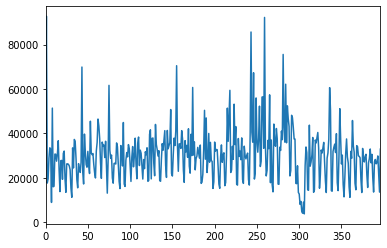

In [48]:
df_train['y'].plot()

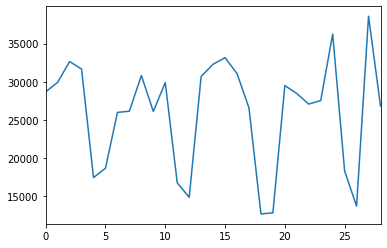

In [49]:
df_test['y'].plot()

In [50]:
len(df_train)

397

In [51]:
len(df_test)

29

# Simple/naive Prophet model

In [52]:
# Setup and train model and fit
model = Prophet()
model.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [53]:
df_test_fcst = model.predict(df_test)

# Prophet Plotting

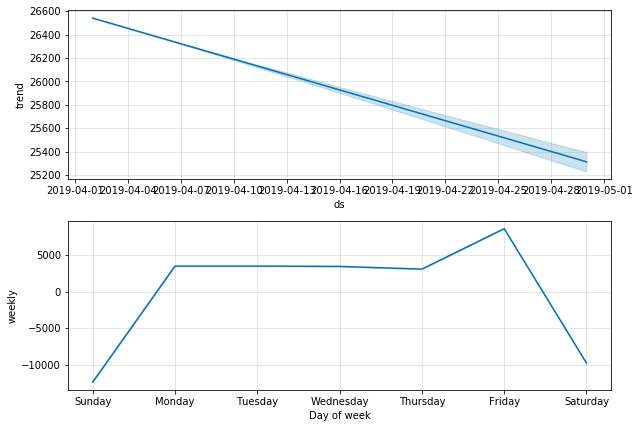

In [54]:
fig = model.plot_components(df_test_fcst)

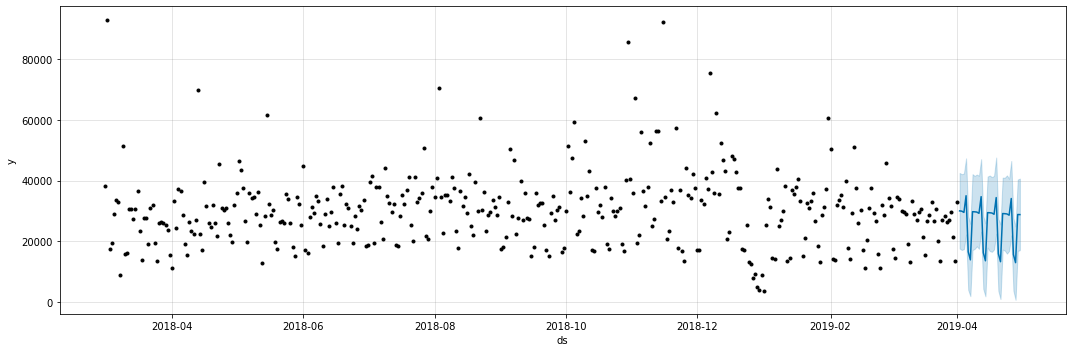

In [55]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

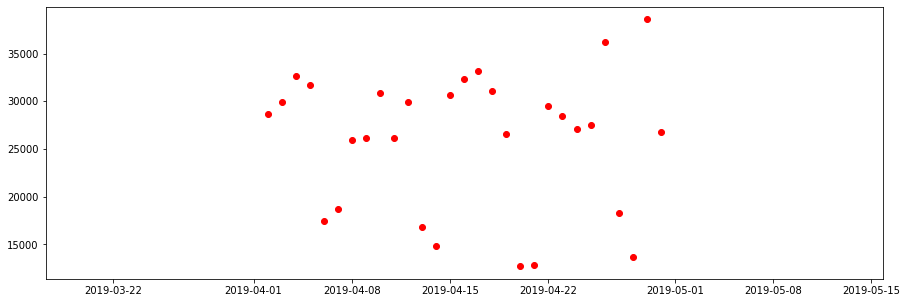

In [56]:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test['ds'], df_test['y'], color='r')

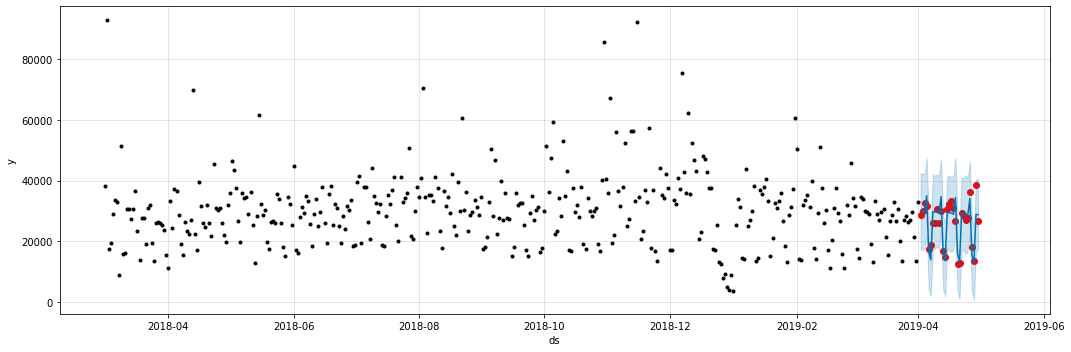

In [57]:
fig = model.plot(df_test_fcst, ax=ax)

fig

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['y'],
                   y_pred=df_test_fcst['yhat'])

10.005029211869637

# Time to look into tweaking the model and other models(XGBoost for example.)

# TBD: Other models

In [59]:
# # For SARIMA Orders we set seasonal=True and pass in an m value
# from pmdarima import auto_arima      
# auto_arima(df_features['y'],seasonal=True,m=7).summary()

# XGBoost model for comparison

In [60]:
df_train = df_train.set_index('ds')

In [61]:
df_test = df_test.set_index('ds')

In [62]:
X_train = df_train.drop('y', axis=1)

In [63]:
y_train = df_train['y']

In [64]:
X_test = df_test.drop('y', axis=1)

In [65]:
y_test = df_test['y']

In [66]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[12:44:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# XGBoost iteration 1 interpretability plots aren't very uhh readable

In [76]:
rcParams['figure.figsize'] = 80,50

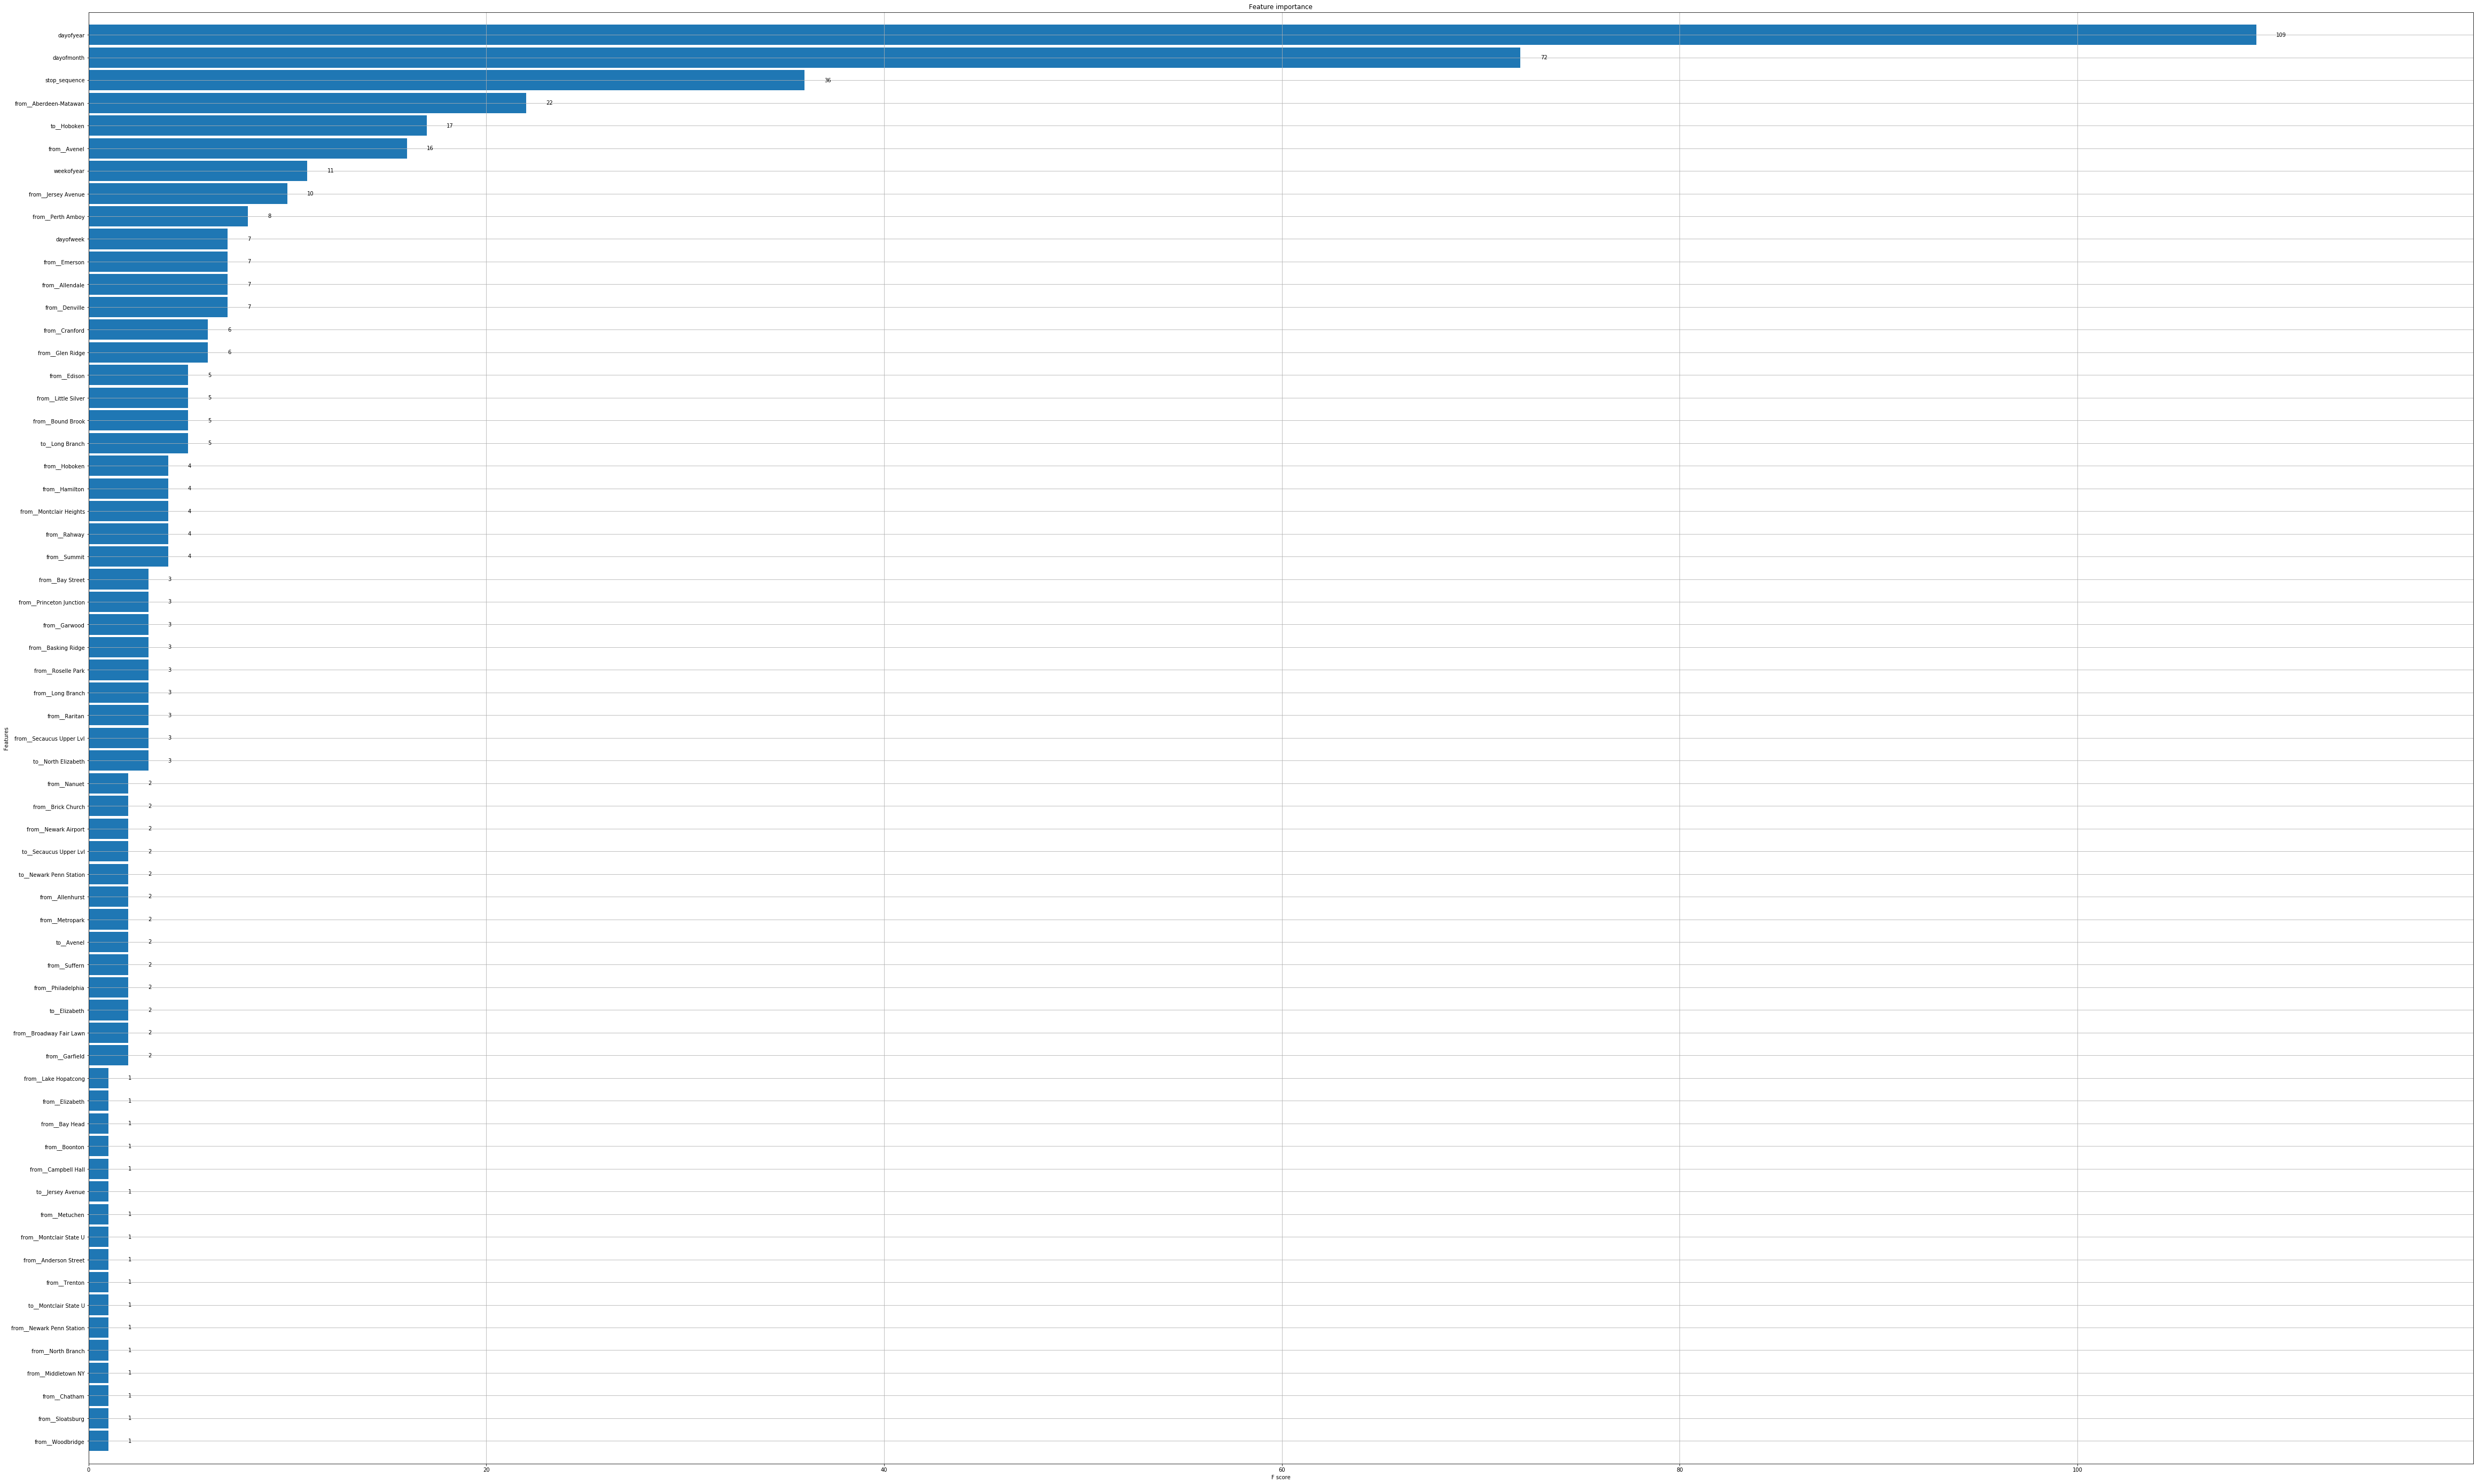

In [77]:
_ = plot_importance(reg, height=0.9)

In [ ]:
_ = plot_importance(reg, height=0.9, importance_type="gain")

In [ ]:
_ = plot_importance(reg, height=0.9, importance_type="cover")

In [82]:
g_import_1 =reg.get_booster().get_score(importance_type="gain")

In [83]:
g_import_1

{'from__Denville': 11671963565.428572,
 'from__Aberdeen-Matawan': 187713167.02272728,
 'from__Allendale': 23091579.42857143,
 'dayofyear': 251543513.96330276,
 'from__Garfield': 66765640.0,
 'from__Broadway Fair Lawn': 549734912.0,
 'to__Elizabeth': 315310080.0,
 'dayofmonth': 295116338.4166667,
 'to__Long Branch': 249990339.2,
 'to__North Elizabeth': 159734442.66666666,
 'from__Summit': 6338801665.0,
 'from__Bound Brook': 415147046.4,
 'to__Hoboken': 257532468.47058824,
 'from__Secaucus Upper Lvl': 262641386.66666666,
 'from__Glen Ridge': 825002850.0,
 'from__Perth Amboy': 1844950454.25,
 'stop_sequence': 276134663.2222222,
 'from__Raritan': 108738805.33333333,
 'from__Philadelphia': 135205760.0,
 'from__Suffern': 65246015.0,
 'from__Woodbridge': 13198128.0,
 'weekofyear': 94952649.9090909,
 'from__Long Branch': 18631856.5,
 'from__Sloatsburg': 70579456.0,
 'from__Avenel': 729287831.5,
 'from__Chatham': 115855104.0,
 'to__Avenel': 844762304.0,
 'from__Little Silver': 363146617.6,
 'fr

In [84]:
{k: v for k, v in sorted(g_import_1.items(), key=lambda item: item[1])}

{'from__Elizabeth': 1727718.0,
 'from__Woodbridge': 13198128.0,
 'from__Anderson Street': 13286084.0,
 'from__Long Branch': 18631856.5,
 'from__Brick Church': 21868032.0,
 'from__Allendale': 23091579.42857143,
 'from__Bay Street': 24491567.333333332,
 'from__Garwood': 34393574.666666664,
 'from__Nanuet': 34756768.0,
 'from__Montclair State U': 40677476.0,
 'from__Edison': 46464328.0,
 'from__Boonton': 57740776.0,
 'from__Lake Hopatcong': 62338312.0,
 'to__Jersey Avenue': 64232868.0,
 'from__Suffern': 65246015.0,
 'from__Cranford': 66391687.0,
 'from__Garfield': 66765640.0,
 'from__Trenton': 69506096.0,
 'to__Newark Penn Station': 70406162.0,
 'from__Sloatsburg': 70579456.0,
 'dayofweek': 80220667.42857143,
 'from__Roselle Park': 81470944.0,
 'from__Bay Head': 88587808.0,
 'weekofyear': 94952649.9090909,
 'from__Metropark': 95850452.0,
 'from__Campbell Hall': 108659280.0,
 'from__Raritan': 108738805.33333333,
 'from__Chatham': 115855104.0,
 'from__Basking Ridge': 119255818.66666667,
 'f

In [86]:
c_import_1 = reg.get_booster().get_score(importance_type="cover")

In [87]:
{k: v for k, v in sorted(c_import_1.items(), key=lambda item: item[1])}

{'dayofweek': 9.428571428571429,
 'to__Avenel': 10.0,
 'from__Elizabeth': 10.0,
 'from__Allendale': 10.142857142857142,
 'from__Newark Airport': 14.0,
 'from__Bay Head': 14.0,
 'from__Woodbridge': 15.0,
 'from__Anderson Street': 15.0,
 'from__Long Branch': 25.333333333333332,
 'from__Edison': 26.4,
 'from__Aberdeen-Matawan': 26.863636363636363,
 'from__Garwood': 28.666666666666668,
 'from__Bay Street': 31.666666666666668,
 'from__Boonton': 41.0,
 'to__Montclair State U': 44.0,
 'from__Campbell Hall': 45.0,
 'from__Brick Church': 66.0,
 'from__Bound Brook': 72.2,
 'from__Cranford': 94.5,
 'from__Sloatsburg': 95.0,
 'from__Princeton Junction': 105.66666666666667,
 'dayofmonth': 114.66666666666667,
 'to__North Elizabeth': 116.66666666666667,
 'from__Philadelphia': 124.0,
 'from__Broadway Fair Lawn': 126.0,
 'from__Roselle Park': 140.33333333333334,
 'from__Chatham': 144.0,
 'to__Long Branch': 145.2,
 'from__Glen Ridge': 147.66666666666666,
 'from__Hamilton': 150.5,
 'from__Little Silver':

In [89]:
import_1 = reg.get_booster().get_score(importance_type="weight")

In [90]:
{k: v for k, v in sorted(import_1.items(), key=lambda item: item[1])}

{'from__Woodbridge': 1,
 'from__Sloatsburg': 1,
 'from__Chatham': 1,
 'from__Middletown NY': 1,
 'from__North Branch': 1,
 'from__Newark Penn Station': 1,
 'to__Montclair State U': 1,
 'from__Trenton': 1,
 'from__Anderson Street': 1,
 'from__Montclair State U': 1,
 'from__Metuchen': 1,
 'to__Jersey Avenue': 1,
 'from__Campbell Hall': 1,
 'from__Boonton': 1,
 'from__Bay Head': 1,
 'from__Elizabeth': 1,
 'from__Lake Hopatcong': 1,
 'from__Garfield': 2,
 'from__Broadway Fair Lawn': 2,
 'to__Elizabeth': 2,
 'from__Philadelphia': 2,
 'from__Suffern': 2,
 'to__Avenel': 2,
 'from__Metropark': 2,
 'from__Allenhurst': 2,
 'to__Newark Penn Station': 2,
 'to__Secaucus Upper Lvl': 2,
 'from__Newark Airport': 2,
 'from__Brick Church': 2,
 'from__Nanuet': 2,
 'to__North Elizabeth': 3,
 'from__Secaucus Upper Lvl': 3,
 'from__Raritan': 3,
 'from__Long Branch': 3,
 'from__Roselle Park': 3,
 'from__Basking Ridge': 3,
 'from__Garwood': 3,
 'from__Princeton Junction': 3,
 'from__Bay Street': 3,
 'from__Su

# Different metrics for feature importance give wildly different results

In [91]:
rcParams['figure.figsize'] = 80,50

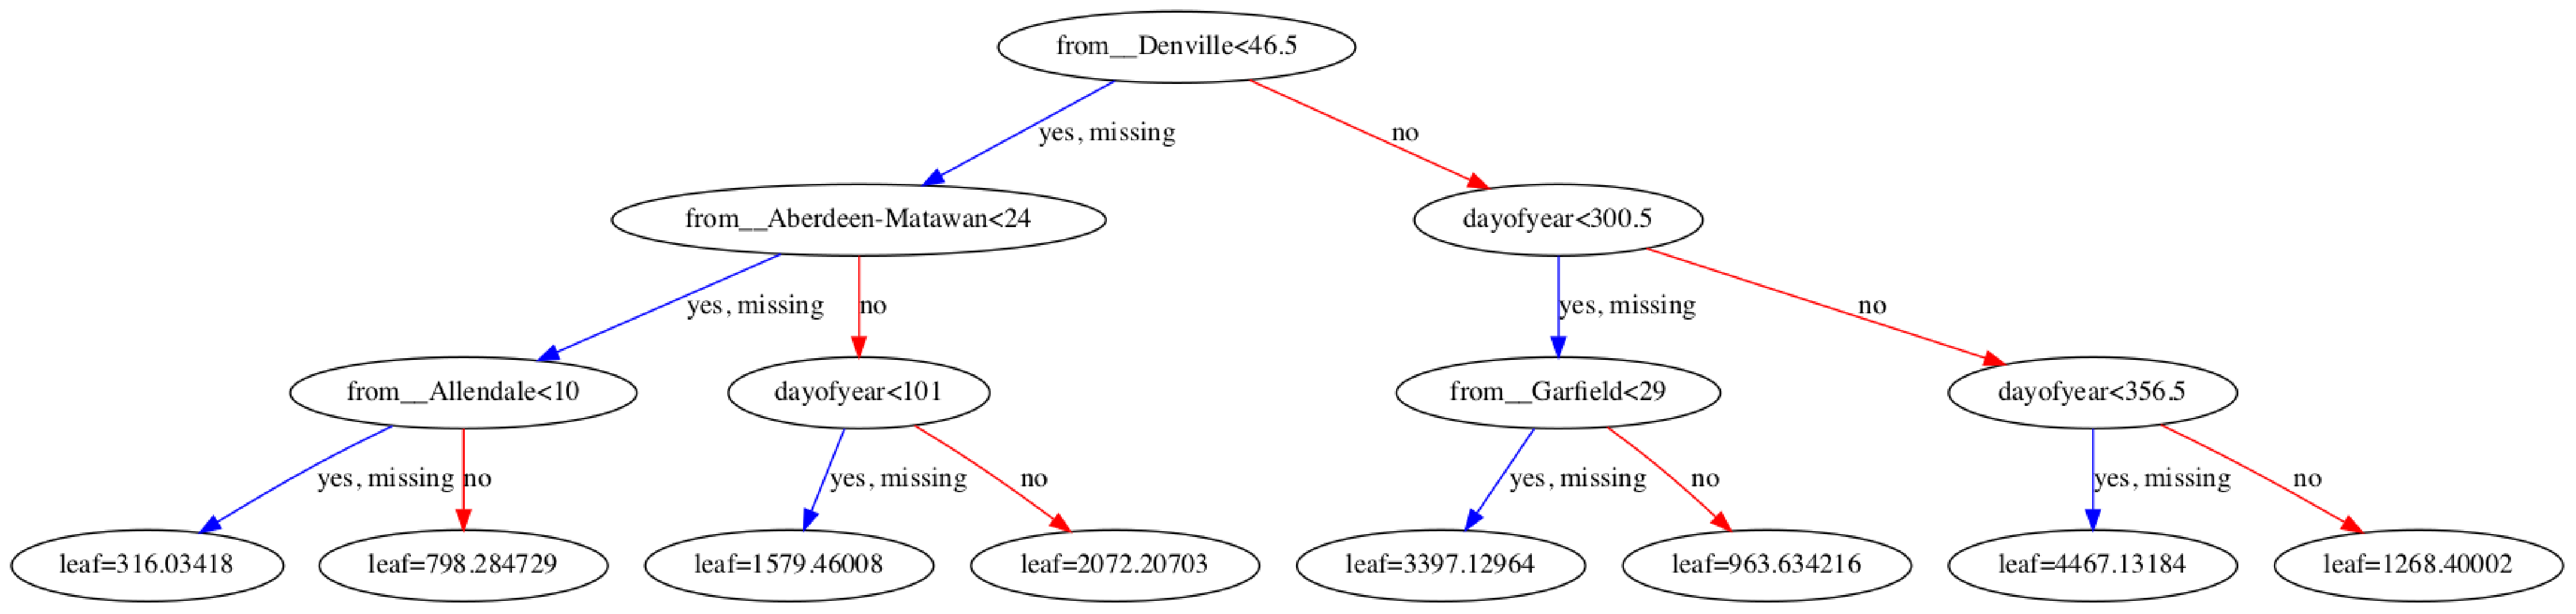

In [92]:
plot_tree(reg)

In [93]:
df_test['Delay_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

# XGBoost 1 Plot against Actual Data

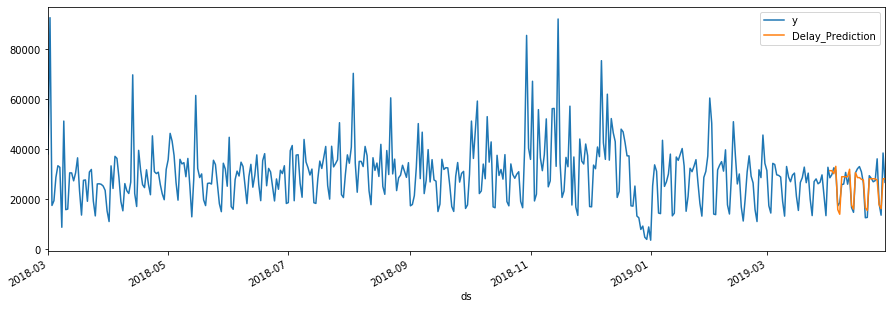

In [94]:
_ = df_all[['y','Delay_Prediction']].plot(figsize=(15, 5))

# MAPE

In [95]:
mean_absolute_percentage_error(y_true=df_test['y'],
                   y_pred=df_test['Delay_Prediction'])

10.41398496671544

# Note to self: How to read this?

In [96]:
shap.initjs()

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)

# first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
